# v9 Training: Improved Cross-Lingual Neural Sparse Model

v8에서 개선된 버전입니다.

## v9 개선 사항
1. **Loss Weight 재조정**: Self-preservation 감소, Target 증가
2. **Margin Loss 강화**: 영어 토큰 최소 활성화 보장
3. **Negative Sampling**: 비타겟 언어(일본어, 중국어 등) 토큰 억제
4. **Epochs 증가**: 3 → 5

## 1. Setup

In [1]:
import sys
import json
import re
from pathlib import Path

def find_project_root():
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.model.splade_model import create_splade_model

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True
Using device: cuda


## 2. Configuration (v9 개선)

In [3]:
# v9 Training configuration with improvements
CONFIG = {
    # Model
    'model_name': 'bert-base-multilingual-cased',
    'max_length': 64,
    
    # Data (reuse v8 data)
    'data_path': PROJECT_ROOT / 'dataset' / 'v8_clustered' / 'synonym_clusters.jsonl',
    
    # Training
    'batch_size': 64,
    'num_epochs': 5,  # v8: 3 -> v9: 5
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'max_grad_norm': 1.0,
    
    # Loss weights (v9 improvements)
    'lambda_self': 0.3,       # v8: 1.0 -> v9: 0.3 (감소)
    'lambda_target': 2.0,     # v8: 1.0 -> v9: 2.0 (증가)
    'lambda_synonym': 1.0,    # v8: 0.5 -> v9: 1.0 (증가)
    'lambda_margin': 1.0,     # v8: 0.3 -> v9: 1.0 (증가)
    'lambda_negative': 0.5,   # NEW: Negative sampling
    'lambda_sparsity': 0.01,
    
    # Margin (v9 improvements)
    'target_margin': 1.5,     # v8: 0.5 -> v9: 1.5 (증가)
    
    # Output
    'output_dir': PROJECT_ROOT / 'outputs' / 'v9_cross_lingual',
}

print("v9 Configuration (Changes from v8 highlighted):")
print("="*60)
v8_config = {
    'lambda_self': 1.0,
    'lambda_target': 1.0,
    'lambda_synonym': 0.5,
    'lambda_margin': 0.3,
    'target_margin': 0.5,
    'num_epochs': 3,
}
for k, v in CONFIG.items():
    if k in v8_config and v8_config[k] != v:
        print(f"  {k}: {v8_config[k]} -> {v} ⭐")
    else:
        print(f"  {k}: {v}")

v9 Configuration (Changes from v8 highlighted):
  model_name: bert-base-multilingual-cased
  max_length: 64
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl
  batch_size: 64
  num_epochs: 3 -> 5 ⭐
  learning_rate: 2e-05
  warmup_ratio: 0.1
  max_grad_norm: 1.0
  lambda_self: 1.0 -> 0.3 ⭐
  lambda_target: 1.0 -> 2.0 ⭐
  lambda_synonym: 0.5 -> 1.0 ⭐
  lambda_margin: 0.3 -> 1.0 ⭐
  lambda_negative: 0.5
  lambda_sparsity: 0.01
  target_margin: 0.5 -> 1.5 ⭐
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual


## 3. Non-Target Language Token Detection

In [4]:
def is_korean_char(c: str) -> bool:
    """Check if character is Korean."""
    return '\uac00' <= c <= '\ud7a3' or '\u1100' <= c <= '\u11ff' or '\u3130' <= c <= '\u318f'

def is_english_char(c: str) -> bool:
    """Check if character is English letter."""
    return c.isalpha() and c.isascii()

def is_non_target_token(token: str) -> bool:
    """
    Check if token is from non-target language (Japanese, Chinese, etc.).
    We want to suppress these tokens.
    """
    clean = token.replace('##', '')
    if not clean:
        return False
    
    # Check if token has Korean or English
    has_korean = any(is_korean_char(c) for c in clean)
    has_english = any(is_english_char(c) for c in clean)
    
    # If it's Korean or English, it's a target language
    if has_korean or has_english:
        return False
    
    # Check for non-target scripts
    # Japanese (Hiragana, Katakana, Kanji)
    has_japanese = any('\u3040' <= c <= '\u309f' or '\u30a0' <= c <= '\u30ff' for c in clean)
    # Chinese (CJK Unified Ideographs) - note: some overlap with Japanese Kanji
    has_cjk = any('\u4e00' <= c <= '\u9fff' for c in clean)
    # Cyrillic
    has_cyrillic = any('\u0400' <= c <= '\u04ff' for c in clean)
    # Arabic
    has_arabic = any('\u0600' <= c <= '\u06ff' for c in clean)
    # Thai
    has_thai = any('\u0e00' <= c <= '\u0e7f' for c in clean)
    # Bengali
    has_bengali = any('\u0980' <= c <= '\u09ff' for c in clean)
    # Myanmar/Burmese
    has_myanmar = any('\u1000' <= c <= '\u109f' for c in clean)
    # Greek
    has_greek = any('\u0370' <= c <= '\u03ff' for c in clean)
    
    return has_japanese or has_cjk or has_cyrillic or has_arabic or has_thai or has_bengali or has_myanmar or has_greek

# Test
test_tokens = ['machine', '머신', '##닝', '学', '##ニング', 'комп', '။', 'мод', '模']
print("Non-target token detection test:")
for tok in test_tokens:
    print(f"  '{tok}': {'NON-TARGET' if is_non_target_token(tok) else 'OK'}")

Non-target token detection test:
  'machine': OK
  '머신': OK
  '##닝': OK
  '学': NON-TARGET
  '##ニング': NON-TARGET
  'комп': NON-TARGET
  '။': NON-TARGET
  'мод': NON-TARGET
  '模': NON-TARGET


In [5]:
# Build non-target token ID list
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

print("Building non-target language token ID list...")
non_target_ids = []

for token_id in tqdm(range(tokenizer.vocab_size)):
    token = tokenizer.convert_ids_to_tokens(token_id)
    if is_non_target_token(token):
        non_target_ids.append(token_id)

non_target_ids_tensor = torch.tensor(non_target_ids, dtype=torch.long)
print(f"Found {len(non_target_ids):,} non-target language tokens")
print(f"Examples: {[tokenizer.convert_ids_to_tokens(i) for i in non_target_ids[:20]]}")

Building non-target language token ID list...


  0%|          | 0/119547 [00:00<?, ?it/s]

Found 36,628 non-target language tokens
Examples: ['΄', 'Ά', 'Έ', 'Ή', 'Ί', 'Ό', 'Ύ', 'Ώ', 'ΐ', 'Α', 'Β', 'Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ']


## 4. Load Dataset

In [6]:
class SynonymClusterDataset(Dataset):
    """Dataset for v9 training with synonym clusters."""
    
    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        print(f"Loading dataset from {data_path}...")
        
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = json.loads(line.strip())
                
                ko_term = item['ko_term']
                en_term = item['en_term']
                
                # Tokenize Korean term
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [tid for tid in ko_token_ids if tid != tokenizer.unk_token_id]
                
                # Tokenize English term
                en_tokens = tokenizer.tokenize(en_term.lower())
                en_token_ids = tokenizer.convert_tokens_to_ids(en_tokens)
                en_token_ids = [tid for tid in en_token_ids if tid != tokenizer.unk_token_id]
                
                # Tokenize synonyms
                ko_syn_ids = []
                for syn in item.get('ko_synonyms', []):
                    syn_tokens = tokenizer.tokenize(syn)
                    syn_ids = tokenizer.convert_tokens_to_ids(syn_tokens)
                    ko_syn_ids.extend([tid for tid in syn_ids if tid != tokenizer.unk_token_id])
                
                en_syn_ids = []
                for syn in item.get('en_synonyms', []):
                    syn_tokens = tokenizer.tokenize(syn.lower())
                    syn_ids = tokenizer.convert_tokens_to_ids(syn_tokens)
                    en_syn_ids.extend([tid for tid in syn_ids if tid != tokenizer.unk_token_id])
                
                if ko_token_ids and en_token_ids:
                    self.data.append({
                        'ko_term': ko_term,
                        'en_term': en_term,
                        'ko_token_ids': ko_token_ids,
                        'en_token_ids': en_token_ids,
                        'ko_syn_ids': list(set(ko_syn_ids))[:10],
                        'en_syn_ids': list(set(en_syn_ids))[:10],
                    })
        
        print(f"Loaded {len(self.data)} samples")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        encoding = self.tokenizer(
            item['ko_term'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'ko_token_ids': item['ko_token_ids'],
            'en_token_ids': item['en_token_ids'],
            'ko_syn_ids': item['ko_syn_ids'],
            'en_syn_ids': item['en_syn_ids'],
        }


def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'ko_token_ids': [item['ko_token_ids'] for item in batch],
        'en_token_ids': [item['en_token_ids'] for item in batch],
        'ko_syn_ids': [item['ko_syn_ids'] for item in batch],
        'en_syn_ids': [item['en_syn_ids'] for item in batch],
    }

In [7]:
# Check if dataset exists
if not CONFIG['data_path'].exists():
    print(f"Dataset not found at {CONFIG['data_path']}")
    print("Please run v8/01_data_preparation_clustering.ipynb first!")
else:
    dataset = SynonymClusterDataset(
        CONFIG['data_path'],
        tokenizer,
        CONFIG['max_length']
    )

    dataloader = DataLoader(
        dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn,
        pin_memory=True
    )

    print(f"Dataset size: {len(dataset):,}")
    print(f"Batches per epoch: {len(dataloader):,}")

Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl...
Loaded 10 samples
Dataset size: 10
Batches per epoch: 1


## 5. v9 Loss Function (Improved)

In [8]:
class V9CrossLingualLoss(nn.Module):
    """
    v9 Improved Loss: Rebalanced weights + Negative Sampling
    
    Changes from v8:
    1. Reduced self-preservation weight (0.3 vs 1.0)
    2. Increased target weight (2.0 vs 1.0)
    3. Stronger margin loss (margin=1.5 vs 0.5)
    4. Added negative sampling for non-target languages
    """
    
    def __init__(self, target_margin: float = 1.5, non_target_ids: torch.Tensor = None):
        super().__init__()
        self.target_margin = target_margin
        self.non_target_ids = non_target_ids
    
    def forward(
        self,
        sparse_rep: torch.Tensor,
        ko_token_ids: list,
        en_token_ids: list,
        ko_syn_ids: list,
        en_syn_ids: list,
    ) -> dict:
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device
        
        self_loss = torch.tensor(0.0, device=device)
        target_loss = torch.tensor(0.0, device=device)
        synonym_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)
        negative_loss = torch.tensor(0.0, device=device)
        
        n_valid = 0
        
        for i in range(batch_size):
            rep = sparse_rep[i]
            
            # 1. Self-preservation loss (Korean tokens)
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()
            
            # 2. English target loss (강화됨)
            if en_token_ids[i]:
                en_ids = torch.tensor(en_token_ids[i], device=device)
                en_activations = rep[en_ids]
                target_loss = target_loss - torch.log(en_activations + 1e-8).mean()
                
                # Stronger margin loss
                margin_loss = margin_loss + F.relu(self.target_margin - en_activations).mean()
            
            # 3. Synonym loss
            all_syn_ids = ko_syn_ids[i] + en_syn_ids[i]
            if all_syn_ids:
                syn_ids = torch.tensor(all_syn_ids, device=device)
                syn_activations = rep[syn_ids]
                synonym_loss = synonym_loss - torch.log(syn_activations + 1e-8).mean()
            
            # 4. Negative sampling loss (NEW in v9)
            # Suppress non-target language tokens
            if self.non_target_ids is not None:
                non_target_ids_device = self.non_target_ids.to(device)
                non_target_activations = rep[non_target_ids_device]
                # Penalize high activations of non-target tokens
                negative_loss = negative_loss + F.relu(non_target_activations - 0.1).mean()
            
            n_valid += 1
        
        if n_valid > 0:
            self_loss = self_loss / n_valid
            target_loss = target_loss / n_valid
            synonym_loss = synonym_loss / n_valid
            margin_loss = margin_loss / n_valid
            negative_loss = negative_loss / n_valid
        
        return {
            'self': self_loss,
            'target': target_loss,
            'synonym': synonym_loss,
            'margin': margin_loss,
            'negative': negative_loss,
        }

## 6. Model and Training Setup

In [9]:
# Create model
model = create_splade_model(
    model_name=CONFIG['model_name'],
    use_idf=False,
    use_expansion=True,
    expansion_mode='mlm',
)
model = model.to(device)

print(f"Model created: {CONFIG['model_name']}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)

Model created: bert-base-multilingual-cased
Total parameters: 177,974,523


In [10]:
# Loss function with non-target IDs
loss_fn = V9CrossLingualLoss(
    target_margin=CONFIG['target_margin'],
    non_target_ids=non_target_ids_tensor
)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=0.01
)

# Scheduler
total_steps = len(dataloader) * CONFIG['num_epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")

Total steps: 5
Warmup steps: 0


## 7. Evaluation Function

In [11]:
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"], ["머신", "러닝"]),
    ("딥러닝", ["deep", "learning"], ["딥", "러닝"]),
    ("자연어처리", ["natural", "language", "processing"], ["자연어", "처리"]),
    ("인공지능", ["artificial", "intelligence"], ["인공", "지능"]),
    ("데이터", ["data"], ["데이터"]),
    ("컴퓨터", ["computer"], ["컴퓨터"]),
    ("네트워크", ["network"], ["네트워크"]),
]

def evaluate_model(model, tokenizer, device, top_k=50):
    """Evaluate model on test pairs."""
    model.eval()
    
    results = []
    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0
    non_target_in_top_total = 0
    
    with torch.no_grad():
        for ko_term, en_expected, ko_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            sparse_rep, _ = model(
                encoding['input_ids'].to(device),
                encoding['attention_mask'].to(device)
            )
            
            sparse_rep = sparse_rep[0].cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
            top_tokens_set = set(top_tokens)
            
            # Count non-target tokens in top-k
            non_target_count = sum(1 for t in top_tokens if is_non_target_token(t))
            non_target_in_top_total += non_target_count
            
            # Check Korean preservation
            ko_activated = []
            for ko in ko_expected:
                ko_toks = tokenizer.tokenize(ko)
                for tok in ko_toks:
                    ko_expected_total += 1
                    if tok in top_tokens_set:
                        ko_activated_total += 1
                        ko_activated.append(tok)
            
            # Check English activation
            en_activated = []
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens_set:
                        en_activated_total += 1
                        en_activated.append(tok)
            
            results.append({
                'input': ko_term,
                'ko_activated': ko_activated,
                'en_activated': en_activated,
                'top_5': top_tokens[:5],
                'non_target_count': non_target_count,
            })
    
    model.train()
    
    ko_rate = ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0
    en_rate = en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0
    avg_non_target = non_target_in_top_total / len(TEST_PAIRS)
    
    return {
        'ko_rate': ko_rate,
        'en_rate': en_rate,
        'avg_non_target': avg_non_target,
        'details': results
    }

In [12]:
# Initial evaluation
print("Initial evaluation (before training):")
init_eval = evaluate_model(model, tokenizer, device)
print(f"  Korean preservation rate: {init_eval['ko_rate']:.1f}%")
print(f"  English activation rate: {init_eval['en_rate']:.1f}%")
print(f"  Avg non-target tokens in top-50: {init_eval['avg_non_target']:.1f}")

Initial evaluation (before training):
  Korean preservation rate: 100.0%
  English activation rate: 0.0%
  Avg non-target tokens in top-50: 18.3


## 8. Training Loop

In [13]:
# Create output directory
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)

# Training history
history = []

print("=" * 70)
print("STARTING TRAINING (v9 - Improved)")
print(f"Epochs: {CONFIG['num_epochs']}")
print("Key improvements:")
print(f"  - Self weight: 0.3 (v8: 1.0)")
print(f"  - Target weight: 2.0 (v8: 1.0)")
print(f"  - Margin: 1.5 (v8: 0.5)")
print(f"  - Negative sampling: ENABLED")
print("=" * 70)

STARTING TRAINING (v9 - Improved)
Epochs: 5
Key improvements:
  - Self weight: 0.3 (v8: 1.0)
  - Target weight: 2.0 (v8: 1.0)
  - Margin: 1.5 (v8: 0.5)
  - Negative sampling: ENABLED


In [14]:
for epoch in range(CONFIG['num_epochs']):
    print(f"\n--- Epoch {epoch + 1}/{CONFIG['num_epochs']} ---")
    model.train()
    
    epoch_losses = {
        'total': 0.0,
        'self': 0.0,
        'target': 0.0,
        'synonym': 0.0,
        'margin': 0.0,
        'negative': 0.0,
        'sparsity': 0.0,
    }
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass
        sparse_rep, _ = model(input_ids, attention_mask)
        
        # Compute losses
        losses = loss_fn(
            sparse_rep,
            batch['ko_token_ids'],
            batch['en_token_ids'],
            batch['ko_syn_ids'],
            batch['en_syn_ids'],
        )
        
        # Sparsity loss
        sparsity_loss = sparse_rep.mean()
        
        # Total loss with v9 weights
        total_loss = (
            CONFIG['lambda_self'] * losses['self'] +
            CONFIG['lambda_target'] * losses['target'] +
            CONFIG['lambda_synonym'] * losses['synonym'] +
            CONFIG['lambda_margin'] * losses['margin'] +
            CONFIG['lambda_negative'] * losses['negative'] +
            CONFIG['lambda_sparsity'] * sparsity_loss
        )
        
        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Accumulate losses
        epoch_losses['total'] += total_loss.item()
        epoch_losses['self'] += losses['self'].item()
        epoch_losses['target'] += losses['target'].item()
        epoch_losses['synonym'] += losses['synonym'].item()
        epoch_losses['margin'] += losses['margin'].item()
        epoch_losses['negative'] += losses['negative'].item()
        epoch_losses['sparsity'] += sparsity_loss.item()
        
        # Update progress bar
        if (batch_idx + 1) % 100 == 0:
            progress_bar.set_postfix({
                'loss': f"{epoch_losses['total'] / (batch_idx + 1):.4f}",
                'tgt': f"{epoch_losses['target'] / (batch_idx + 1):.4f}",
                'neg': f"{epoch_losses['negative'] / (batch_idx + 1):.4f}",
            })
    
    # Average losses
    n_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches
    
    history.append(epoch_losses)
    
    # Evaluate
    eval_result = evaluate_model(model, tokenizer, device)
    
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Self Loss: {epoch_losses['self']:.4f}")
    print(f"  Target Loss: {epoch_losses['target']:.4f}")
    print(f"  Negative Loss: {epoch_losses['negative']:.4f}")
    print(f"  Korean Preservation: {eval_result['ko_rate']:.1f}%")
    print(f"  English Activation: {eval_result['en_rate']:.1f}%")
    print(f"  Avg Non-target in Top-50: {eval_result['avg_non_target']:.1f}")
    
    # Save checkpoint
    checkpoint_path = CONFIG['output_dir'] / f'checkpoint_epoch{epoch + 1}.pt'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': epoch_losses,
        'eval': eval_result,
    }, checkpoint_path)
    print(f"  Saved: {checkpoint_path}")


--- Epoch 1/5 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 1 Summary:
  Total Loss: 4.8752
  Self Loss: -1.0990
  Target Loss: 1.7228
  Negative Loss: 0.1120
  Korean Preservation: 100.0%
  English Activation: 0.0%
  Avg Non-target in Top-50: 12.7
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/checkpoint_epoch1.pt

--- Epoch 2/5 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 2 Summary:
  Total Loss: 0.3010
  Self Loss: -1.1350
  Target Loss: 0.2212
  Negative Loss: 0.1308
  Korean Preservation: 100.0%
  English Activation: 8.3%
  Avg Non-target in Top-50: 14.6
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/checkpoint_epoch2.pt

--- Epoch 3/5 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 3 Summary:
  Total Loss: -1.9603
  Self Loss: -1.1476
  Target Loss: -0.5587
  Negative Loss: 0.1920
  Korean Preservation: 100.0%
  English Activation: 8.3%
  Avg Non-target in Top-50: 13.4


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self.run()
 

  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/checkpoint_epoch3.pt

--- Epoch 4/5 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 4 Summary:
  Total Loss: -2.2057
  Self Loss: -1.1667
  Target Loss: -0.6710
  Negative Loss: 0.1897
  Korean Preservation: 100.0%
  English Activation: 8.3%
  Avg Non-target in Top-50: 10.6
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/checkpoint_epoch4.pt

--- Epoch 5/5 ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 5 Summary:
  Total Loss: -2.8994
  Self Loss: -1.1757
  Target Loss: -0.9542
  Negative Loss: 0.1919
  Korean Preservation: 100.0%
  English Activation: 25.0%
  Avg Non-target in Top-50: 10.0
  Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/checkpoint_epoch5.pt


## 9. Save Final Model

In [15]:
# Save final model
final_path = CONFIG['output_dir'] / 'final_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
    'history': history,
}, final_path)

print(f"Final model saved: {final_path}")

# Save training history
with open(CONFIG['output_dir'] / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("Training history saved")

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1010, in run
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call

Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual/final_model.pt
Training history saved


## 10. Final Evaluation & Comparison

In [16]:
# Final evaluation
print("\n" + "=" * 70)
print("FINAL EVALUATION")
print("=" * 70)

final_eval = evaluate_model(model, tokenizer, device)

print(f"\nKorean Preservation Rate: {final_eval['ko_rate']:.1f}%")
print(f"English Activation Rate: {final_eval['en_rate']:.1f}%")
print(f"Avg Non-target in Top-50: {final_eval['avg_non_target']:.1f}")

print("\nDetailed Results:")
for result in final_eval['details']:
    print(f"\n  Input: {result['input']}")
    print(f"    Korean activated: {result['ko_activated']}")
    print(f"    English activated: {result['en_activated']}")
    print(f"    Top-5: {result['top_5']}")
    print(f"    Non-target count: {result['non_target_count']}")


FINAL EVALUATION

Korean Preservation Rate: 100.0%
English Activation Rate: 25.0%
Avg Non-target in Top-50: 10.0

Detailed Results:

  Input: 머신러닝
    Korean activated: ['머신', '러', '##닝']
    English activated: ['machine']
    Top-5: ['##러', '##닝', '머신', '##로', '##런']
    Non-target count: 6

  Input: 딥러닝
    Korean activated: ['딥', '러', '##닝']
    English activated: []
    Top-5: ['##닝', '##러', '딥', '##로', '##루']
    Non-target count: 1

  Input: 자연어처리
    Korean activated: ['자', '##연', '##어', '처', '##리']
    English activated: []
    Top-5: ['##리', '##처', '##연', '자', '##어']
    Non-target count: 2

  Input: 인공지능
    Korean activated: ['인', '##공', '지', '##능']
    English activated: []
    Top-5: ['##공', '##지', '##능', '인', '지']
    Non-target count: 0

  Input: 데이터
    Korean activated: ['데', '##이터']
    English activated: ['data']
    Top-5: ['데', '##이터', '##데', '指', '##프트']
    Non-target count: 18

  Input: 컴퓨터
    Korean activated: ['컴', '##퓨', '##터']
    English activated: []
   

In [17]:
# v8 vs v9 Comparison
print("\n" + "=" * 70)
print("v8 vs v9 COMPARISON")
print("=" * 70)

# v8 results (from training output)
v8_results = {
    'ko_rate': 100.0,
    'en_rate': 14.3,
}

print(f"\n{'Metric':<25} {'v8':>10} {'v9':>10} {'Change':>12}")
print("-" * 60)
print(f"{'Korean Preservation':<25} {v8_results['ko_rate']:>9.1f}% {final_eval['ko_rate']:>9.1f}% {final_eval['ko_rate'] - v8_results['ko_rate']:>+10.1f}%")
print(f"{'English Activation':<25} {v8_results['en_rate']:>9.1f}% {final_eval['en_rate']:>9.1f}% {final_eval['en_rate'] - v8_results['en_rate']:>+10.1f}%")


v8 vs v9 COMPARISON

Metric                            v8         v9       Change
------------------------------------------------------------
Korean Preservation           100.0%     100.0%       +0.0%
English Activation             14.3%      25.0%      +10.7%


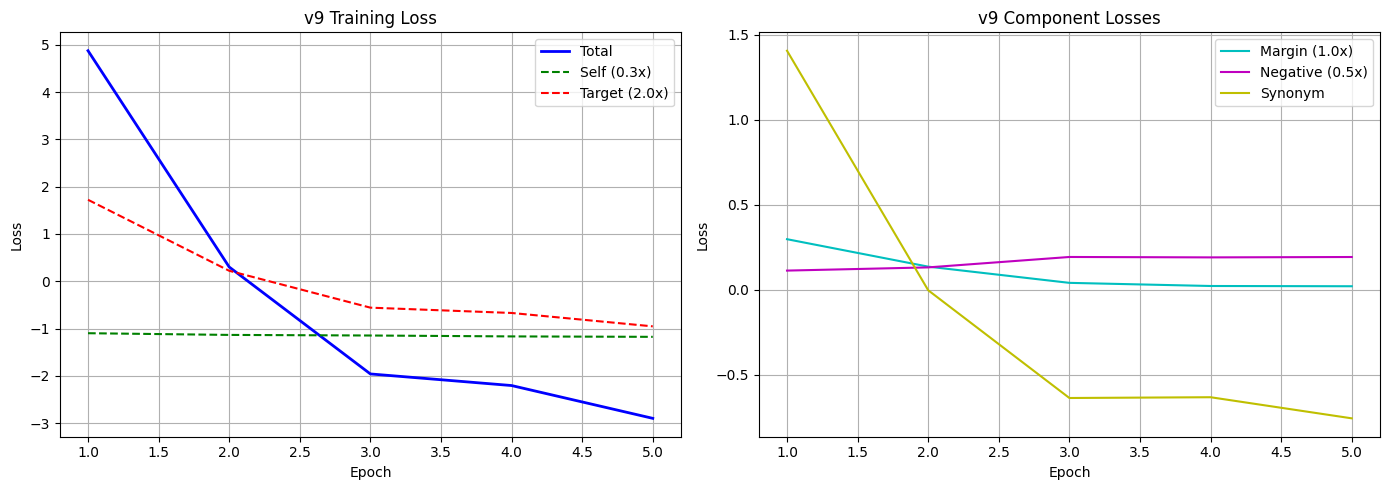

In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history) + 1)

# Main losses
axes[0].plot(epochs, [h['total'] for h in history], 'b-', label='Total', linewidth=2)
axes[0].plot(epochs, [h['self'] for h in history], 'g--', label='Self (0.3x)')
axes[0].plot(epochs, [h['target'] for h in history], 'r--', label='Target (2.0x)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('v9 Training Loss')
axes[0].legend()
axes[0].grid(True)

# Component losses
axes[1].plot(epochs, [h['margin'] for h in history], 'c-', label='Margin (1.0x)')
axes[1].plot(epochs, [h['negative'] for h in history], 'm-', label='Negative (0.5x)')
axes[1].plot(epochs, [h['synonym'] for h in history], 'y-', label='Synonym')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('v9 Component Losses')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'] / 'training_curves.png', dpi=150)
plt.show()

## 11. Summary

### v9 Improvements

| Parameter | v8 | v9 | Change |
|-----------|----|----|--------|
| lambda_self | 1.0 | 0.3 | -70% |
| lambda_target | 1.0 | 2.0 | +100% |
| lambda_margin | 0.3 | 1.0 | +233% |
| target_margin | 0.5 | 1.5 | +200% |
| lambda_negative | - | 0.5 | NEW |
| num_epochs | 3 | 5 | +67% |

In [19]:
print("\n" + "=" * 70)
print("v9 TRAINING COMPLETE")
print("=" * 70)
print(f"\nOutput directory: {CONFIG['output_dir']}")
print(f"\nNext step: Run 02_inference_test.ipynb for detailed evaluation")


v9 TRAINING COMPLETE

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v9_cross_lingual

Next step: Run 02_inference_test.ipynb for detailed evaluation
